In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-28 16:39:30,177	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.8.0


In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def apply_transforms(batch):
    # Instead of passing transforms to CIFAR10(..., transform=transform)
    # we will use this function to dataset.with_transform(apply_transforms)
    # The transforms object is exactly the same
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    batch["img"] = [transform(img) for img in batch["img"]]
    return batch

def load_datasets():
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

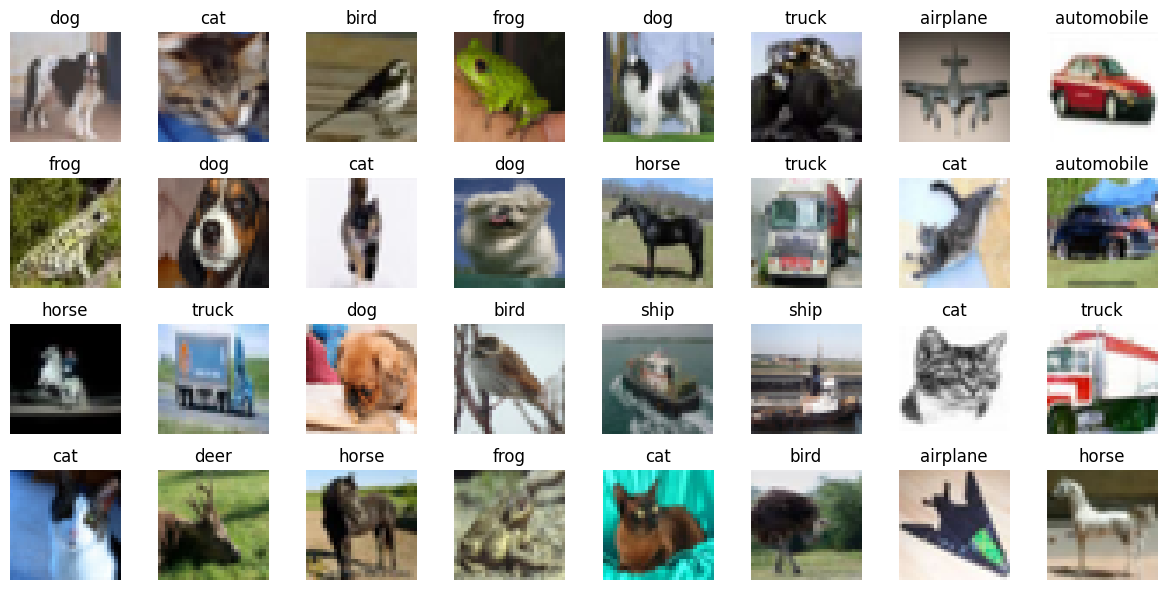

In [3]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

### Step 1: Centralized Training with PyTorch

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.05950738131999969, accuracy 0.33
Epoch 2: validation loss 0.05374207019805908, accuracy 0.385
Epoch 3: validation loss 0.05102946400642395, accuracy 0.429
Epoch 4: validation loss 0.049310852885246274, accuracy 0.449
Epoch 5: validation loss 0.04802072298526764, accuracy 0.463
Final test set performance:
	loss 0.04830160825252533
	accuracy 0.4372


### Step 2: Federated Learning with Flower

In [7]:
# Actualizamos el modelo local con los pesos del servidor
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Cogemos los pesos del modelo local para enviarselo al servidor.
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

#### Flower Client

To implement the Flower client, we create a subclass of flwr.client.NumPyClient and implement the three methods get_parameters, fit, and evaluate:

- get_parameters: Return the current local model parameters
- fit: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
- evaluate: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

In [8]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        # Return the current local model parameters
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        # Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [9]:
# Optimze way to create clients only to execute in the same machine.
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

In [10]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-05-28 17:37:48,680	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=9.28gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-28 17:37:48,859	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 18120835892.0, 'CPU': 12.0, 'node:172.21.0.2': 1.0, 'object_store_memory': 9060417945.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual C

History (loss, distributed):
('\tround 1: 0.06399507234096527\n'
 '\tround 2: 0.05669124627113342\n'
 '\tround 3: 0.053414427161216735\n'
 '\tround 4: 0.051443906736373904\n'
 '\tround 5: 0.04888592677116394\n')

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [12]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-05-28 18:29:45,266	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=9.26gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-28 18:29:45,421	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 9042387763.0, 'memory': 18084775527.0, 'CPU': 12.0, 'node:172.21.0.2': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual C

History (loss, distributed):
('\tround 1: 0.06409603316783904\n'
 '\tround 2: 0.056567532420158384\n'
 '\tround 3: 0.05366362693309783\n'
 '\tround 4: 0.051402324485778805\n'
 '\tround 5: 0.049329453706741334\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.307),
              (2, 0.351),
              (3, 0.3824),
              (4, 0.41320000000000007),
              (5, 0.43479999999999996)]}

In [ ]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)